In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline
from __future__ import division
import matplotlib
import numpy as np
from pylab import *
import os
import warnings
matplotlib.rcParams.update({"axes.formatter.limits": (-4,4)})
plotStyles={"markersize":20,"markeredgewidth":3.0,"linewidth":3.0}
stepStyles={"markersize":20,"markeredgewidth":3.0,"linewidth":3.0,"where":"post"}
np.seterr(divide='ignore',invalid='ignore')
pass

# Setup the notebook.

In [3]:
import h5py
import math
import random
testNames=["rdme_bc_periodic_x","rdme_bc_periodic_y","rdme_bc_periodic_z"]
test_names_bash_list=" ".join(testNames)

In [4]:
%%bash
rm -rf tmp && mkdir tmp

In [5]:
def isclose(a, b, rel_tol=1e-09, abs_tol=0.0):
    return abs(a-b) <= max(rel_tol * max(abs(a), abs(b)), abs_tol)

In [6]:
def buildLattice(filename, axis):
    fp = h5py.File(filename, "a")
    sites=fp["/Model/Diffusion/LatticeSites"]
    if axis == 'x':
        sites[0:3,:,:] = 0
        sites[3,:,:] = 1
        sites[4:7,:,:] = 2
    elif axis == 'y':
        sites[:,0:3,:] = 0
        sites[:,3,:] = 1
        sites[:,4:7,:] = 2
    elif axis == 'z':
        sites[:,:,0:3] = 0
        sites[:,:,3] = 1
        sites[:,:,4:7] = 2
    initialCounts=fp["/Model/Reaction/InitialSpeciesCounts"]
    particles=fp["/Model/Diffusion/Lattice"]
    for i in range(len(initialCounts)):
        attempts = 0
        placed = 0
        while placed < initialCounts[i]:
            attempts += 1
            x = random.randint(0,particles.shape[0]-1)
            y = random.randint(0,particles.shape[1]-1)
            z = random.randint(0,particles.shape[2]-1)
            if (i == 0 and sites[x,y,z] == 0) or (i == 1 and sites[x,y,z] == 2):
                for p in range(particles.shape[3]):
                    if particles[x,y,z,p] == 0xFF:
                        particles[x,y,z,p] = i
                        placed += 1
                        break
        print "Placed %d particles of type %d in %d attempts."%(placed,i,attempts)
    fp.close()

# Execute the simulations.

In [7]:
%%bash -s "$test_names_bash_list"
sbmlFilename="rdme_bimolecular.sbml"
for testName in $1; do
    outputFilename=tmp/${testName}.lm
    rm -f ${outputFilename}*
    lm_sbml_import ${outputFilename} ${sbmlFilename} > ${outputFilename}.import.log
    lm_setp ${outputFilename} maxTime=1e3 writeInterval=1e0 latticeWriteInterval=1e0 > /dev/null
    if [ ${testName} == "rdme_bc_periodic_x" ]; then
        lm_setdm ${outputFilename} PlaceParticles=0 numberReactions=2 numberSpecies=3 numberSiteTypes=3 "latticeSize=[7,5,5]" latticeSpacing=1e-6 particlesPerSite=16 "DiffusionMatrix(:,:,0)=[1e-10,0,1e-10;0,0,0;1e-10,0,1e-10;]" "DiffusionMatrix(:,:,1)=[1e-10,0,1e-10;0,0,0;1e-10,0,1e-10;]" "DiffusionMatrix(:,:,2)=[1e-10,0,1e-10;0,0,0;1e-10,0,1e-10;]" "ReactionLocationMatrix=[1,0,1;1,0,1]" > ${outputFilename}.setdm.log
        lm_setp ${outputFilename} boundaryConditions=x:PERIODIC,y:REFLECTING,z:REFLECTING > /dev/null
    elif [ ${testName} == "rdme_bc_periodic_y" ]; then
        lm_setdm ${outputFilename} PlaceParticles=0 numberReactions=2 numberSpecies=3 numberSiteTypes=3 "latticeSize=[5,7,5]" latticeSpacing=1e-6 particlesPerSite=16 "DiffusionMatrix(:,:,0)=[1e-10,0,1e-10;0,0,0;1e-10,0,1e-10;]" "DiffusionMatrix(:,:,1)=[1e-10,0,1e-10;0,0,0;1e-10,0,1e-10;]" "DiffusionMatrix(:,:,2)=[1e-10,0,1e-10;0,0,0;1e-10,0,1e-10;]" "ReactionLocationMatrix=[1,0,1;1,0,1]" > ${outputFilename}.setdm.log
        lm_setp ${outputFilename} boundaryConditions=x:REFLECTING,y:PERIODIC,z:REFLECTING > /dev/null
    elif [ ${testName} == "rdme_bc_periodic_z" ]; then
        lm_setdm ${outputFilename} PlaceParticles=0 numberReactions=2 numberSpecies=3 numberSiteTypes=3 "latticeSize=[5,5,7]" latticeSpacing=1e-6 particlesPerSite=16 "DiffusionMatrix(:,:,0)=[1e-10,0,1e-10;0,0,0;1e-10,0,1e-10;]" "DiffusionMatrix(:,:,1)=[1e-10,0,1e-10;0,0,0;1e-10,0,1e-10;]" "DiffusionMatrix(:,:,2)=[1e-10,0,1e-10;0,0,0;1e-10,0,1e-10;]" "ReactionLocationMatrix=[1,0,1;1,0,1]" > ${outputFilename}.setdm.log
        lm_setp ${outputFilename} boundaryConditions=x:REFLECTING,y:REFLECTING,z:PERIODIC > /dev/null
    else
        echo "Invalid test name: ${testName}"
        continue
    fi
done;
echo "Finished."

Finished.


In [8]:
# Construct the partitioned lattices.
for testName in testNames:
    buildLattice("tmp/%s.lm"%(testName), testName[-1])
print "Finished."

Placed 100 particles of type 0 in 232 attempts.
Placed 100 particles of type 1 in 252 attempts.
Placed 0 particles of type 2 in 0 attempts.
Placed 100 particles of type 0 in 231 attempts.
Placed 100 particles of type 1 in 243 attempts.
Placed 0 particles of type 2 in 0 attempts.
Placed 100 particles of type 0 in 221 attempts.
Placed 100 particles of type 1 in 231 attempts.
Placed 0 particles of type 2 in 0 attempts.
Finished.


In [9]:
%%bash -s "$test_names_bash_list"
for testName in $1; do
    outputFilename=tmp/${testName}.lm
    lmes -sp -r 1-10 -f ${outputFilename} > ${outputFilename}.simulate.log
done;
echo "Finished."

Finished.


# Define some tests.

In [10]:
def test_stats(testOutputFilename):
    
    # Calcualte some statistics about the species counts.
    fp = h5py.File(testOutputFilename, "r")
    replicates=fp["/Simulations"].keys()
    k=0
    mSim=None
    vSim=None
    times=None
    countsList = []
    for replicate in replicates:
        if times is None:
            times = np.array(fp["/Simulations/%s/SpeciesCountTimes"%replicate], dtype=double)
        counts = np.array(fp["/Simulations/%s/SpeciesCounts"%replicate], dtype=double)
        countsList.append(counts)
        if mSim is None:
            k += 1
            mSim = counts
            vSim = np.zeros(counts.shape, dtype=double)
        else:
            k += 1
            mSim = mSim + (counts-mSim)/k
            vSim = vSim + (counts-mSim)*(counts-mSim)
    vSim /= float((k-1))

    countsArr = np.dstack(countsList)
    
    # Plot the mean and variance.
    matplotlib.rcParams.update({'font.size': 15, "figure.figsize": (15,3)})
    ax=plt.subplot(1,2,1)
    plt.plot(times,mSim[:,0], **plotStyles)
    plt.plot(times,mSim[:,1], **plotStyles)
    plt.plot(times,mSim[:,2], **plotStyles)
    ax.set_yscale('log'); xlabel('t'); ylabel('E{X(t)}'); title("%s"%(testOutputFilename))
    ax=plt.subplot(1,2,2)
    plt.plot(times,vSim[:,0], **plotStyles)
    plt.plot(times,vSim[:,1], **plotStyles)
    plt.plot(times,vSim[:,2], **plotStyles)
    ax.set_yscale('log'); xlabel('t'); ylabel('Var{X(t)}'); title("%s"%(testOutputFilename))
    fp.close()

    # Check the mean and variance.
    value = np.mean(mSim[len(mSim)//2:, 0])
    if not isclose(value,47.3,1e-2): warnings.warn("incorrect value for particle 0 mean " + str(value))
    value = np.mean(mSim[len(mSim)//2:, 1])
    if not isclose(value,47.3,1e-2): warnings.warn("incorrect value for particle 1 mean " + str(value))
    value = np.mean(mSim[len(mSim)//2:, 2])
    if not isclose(value,52.7,1e-2): warnings.warn("incorrect value for particle 2 mean " + str(value))
    value = np.mean(vSim[len(mSim)//2:, 0])
    if not isclose(value,12.2,1e-1): warnings.warn("incorrect value for particle 0 variance " + str(value))
    value = np.mean(vSim[len(mSim)//2:, 1])
    if not isclose(value,12.2,1e-1): warnings.warn("incorrect value for particle 1 variance " + str(value))
    value = np.mean(vSim[len(mSim)//2:, 2])
    if not isclose(value,12.2,1e-1): warnings.warn("incorrect value for particle 2 variance " + str(value))
    
    # return some info to help with debugging tests
    return mSim,vSim,countsArr

In [11]:
def test_density_x(testOutputFilename):
    test_density(testOutputFilename,'x')
def test_density_y(testOutputFilename):
    test_density(testOutputFilename,'y')
def test_density_z(testOutputFilename):
    test_density(testOutputFilename,'z')
def test_density(testOutputFilename, axis):
    
    # Calculate some statistic about the spatial density.
    fp = h5py.File(testOutputFilename, "r")
    replicates=fp["/Simulations"].keys()
    k=0
    mSim=None
    vSim=None
    times=None
    count = 0
    lc = None
    for replicate in replicates:
        lattices=fp["/Simulations/%s/Lattice"%replicate].keys()
        for lattice in lattices:
            lfull = np.array(fp["/Simulations/%s/Lattice/%s"%(replicate,lattice)], dtype=np.uint8)
            if lc is None:
                lc = np.zeros(lfull.shape[0:3]+(3,), dtype=double)
            lc[:,:,:,0] += np.sum(lfull==0,3)
            lc[:,:,:,1] += np.sum(lfull==1,3)
            lc[:,:,:,2] += np.sum(lfull==2,3)
            count += 1
    lc /= count
    fp.close()
    
    if axis == 'x':
        axisIndex=0
        unusedAxisIndices=(1,2)
    elif axis == 'y':
        axisIndex=1
        unusedAxisIndices=(0,2)
    elif axis == 'z':
        axisIndex=2
        unusedAxisIndices=(0,1)
    
    # Plot the mean spatial density.
    for s in range(0,3):
        for i in range(0,lc.shape[axisIndex]):
            if axis == 'x':
                sl=lc[i,:,:,s]
            elif axis == 'y':
                sl=lc[:,i,:,s]
            elif axis == 'z':
                sl=lc[:,:,i,s]
            plt.subplot(3,lc.shape[axisIndex],s*lc.shape[axisIndex]+i+1)
            plt.imshow(sl, cmap=plt.cm.gray, origin='lower', interpolation="none", vmin=0.0, vmax=1.0)
    
    # Check the spatial density.
    expectedValues = (0.31, 0.31, 0.35)
    for s in range(0,3):
        for i in range(0,lc.shape[axisIndex]):
            if axis == 'x':
                sl=lc[i,:,:,s]
            elif axis == 'y':
                sl=lc[:,i,:,s]
            elif axis == 'z':
                sl=lc[:,:,i,s]
            value = np.mean(sl)
            if i == lc.shape[axisIndex]//2:
                if not isclose(value,0.0,1e-1): warnings.warn("incorrect value for mean at p=%d i=%d"%(s,i) + str(value))
            else:
                if not isclose(value,expectedValues[s],1e-1): warnings.warn("incorrect value for mean at p=%d i=%d"%(s,i) + str(value))


In [12]:
def test_compare(testOutputFilename):
    
    # Compare the species and lattice counts.
    fp = h5py.File(testOutputFilename, "r")
    replicates=fp["/Simulations"].keys()
    xs=[]
    ys=[]
    for replicate in replicates:
        counts=np.array(fp["/Simulations/%s/SpeciesCounts"%replicate], dtype=double)
        for i in range(0,counts.shape[0]):
            xs.append(counts[i,2])
        lattices=fp["/Simulations/%s/Lattice"%replicate].keys()
        for lattice in lattices:
            lfull = np.array(fp["/Simulations/%s/Lattice/%s"%(replicate,lattice)], dtype=np.uint8)
            ys.append(np.sum(lfull==2))
            
    # Plot the comparison.
    xmax = np.max(xs)
    plt.plot(xs, ys, ls="None", marker='.', ms=12)
    plt.plot([-10, xmax + 10], [-10, xmax + 10], '--', lw=.5, c='k')
    
    plt.xlim(0, xmax + 1)
    plt.ylim(0, xmax + 1)
    
    plt.xlabel('species counts')
    plt.ylabel('lattice counts')
    
    # Check the comparison.
    for i in range(len(xs)):
        if xs[i] != ys[i]:
            warnings.warn("mismatch in counts at step %d: %d, %d" % (i, xs[i], ys[i]))

# Run the tests.

[rdme_bc_periodic_x:0]                                       : passed.


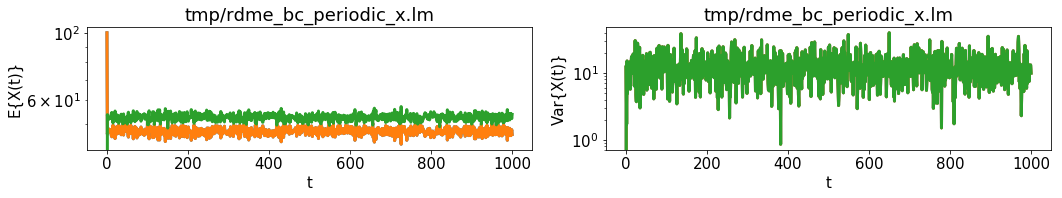

[rdme_bc_periodic_x:1]                                       : passed.


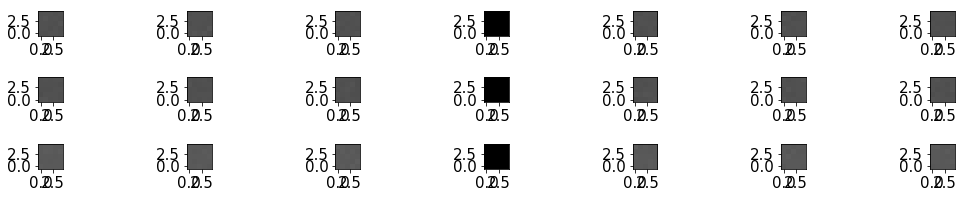

[rdme_bc_periodic_x:2]                                       : passed.


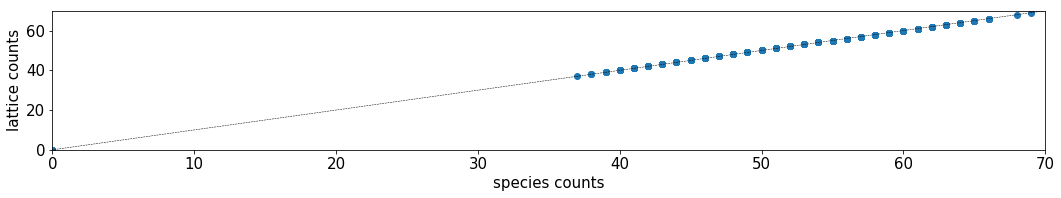

[rdme_bc_periodic_y:0]                                       : passed.


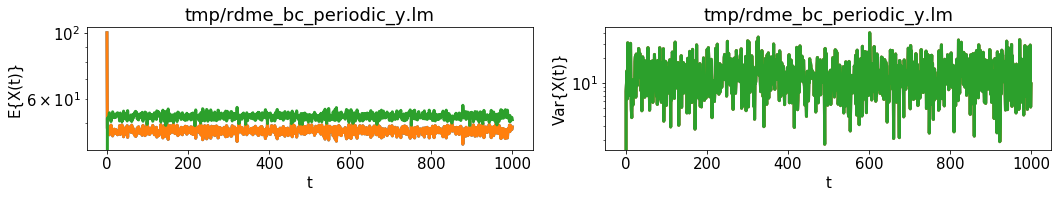

[rdme_bc_periodic_y:1]                                       : passed.


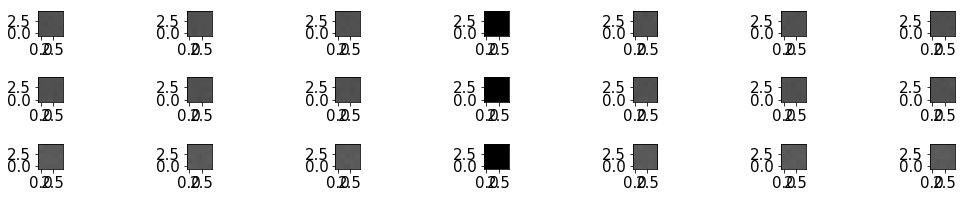

[rdme_bc_periodic_y:2]                                       : passed.


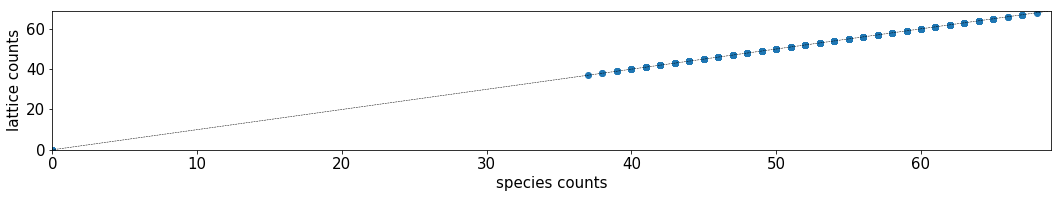

[rdme_bc_periodic_z:0]                                       : passed.


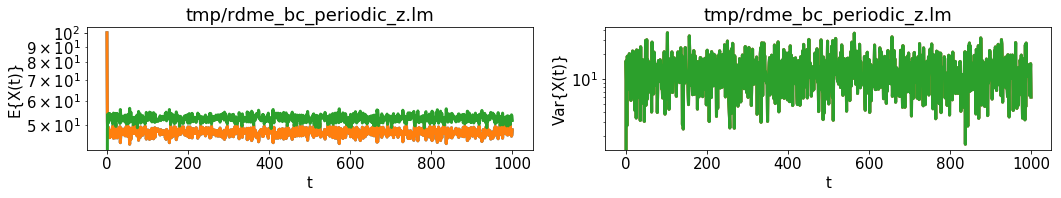

[rdme_bc_periodic_z:1]                                       : passed.


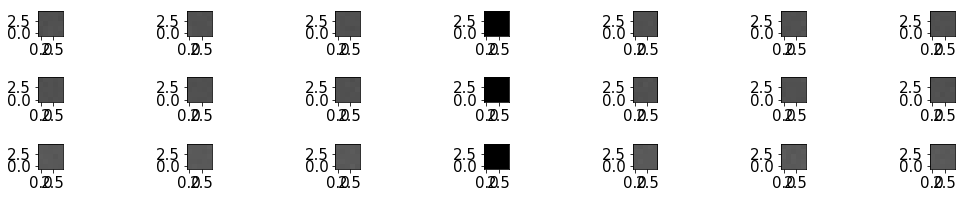

[rdme_bc_periodic_z:2]                                       : passed.


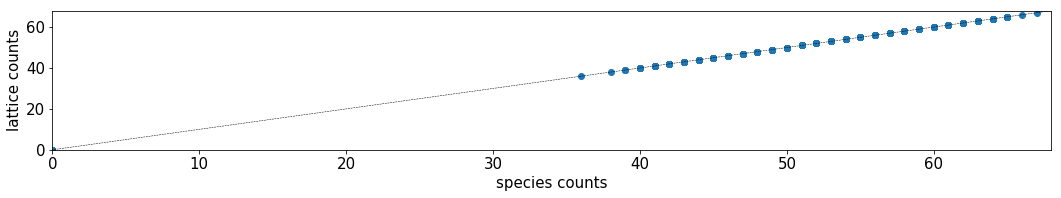

In [13]:
testMethods = {"rdme_bc_periodic_x": [test_stats,test_density_x,test_compare],
               "rdme_bc_periodic_y": [test_stats,test_density_y,test_compare],
               "rdme_bc_periodic_z": [test_stats,test_density_z,test_compare]}
matplotlib.rcParams.update({'font.size': 15, "figure.figsize": (20,5)})
i=1
for testName in testNames:
    for i,testMethod in enumerate(testMethods[testName]):
        try:
            testOutputFilename="tmp/%s.lm"%(testName)
            testMethod(testOutputFilename)
        except Exception as e:
            print "%-60s : FAILED with:"%("["+testName+":"+str(i)+"]"),e
            raise
        except:
            print "%-60s : FAILED with: Unknown exception"%("["+testName+":"+str(i)+"]")
        else:
            print "%-60s : passed."%("["+testName+":"+str(i)+"]")
        plt.tight_layout()
        plt.show()
pass

In [17]:
%%bash
rm -rf tmp